In [1]:
#reference for the code: https://www.kaggle.com/bmendes00/bird-image-classification-using-cnns

In [8]:
# to import cv2; might need to install opencv
# pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
top_path = '../data/10-bird-species/train'
birds = np.array(list(os.listdir(top_path)))

In [15]:
idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'AFRICAN CROWNED CRANE', 1: 'AFRICAN FIREFINCH', 2: 'ALBATROSS', 3: 'ALEXANDRINE PARAKEET', 4: 'AMERICAN AVOCET', 5: 'AMERICAN BITTERN', 6: 'AMERICAN COOT', 7: 'AMERICAN GOLDFINCH', 8: 'AMERICAN KESTREL', 9: 'AMERICAN PIPIT'}


In [16]:
def get_data_labels(path, birds, dim):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dim, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
    return np.array(data), np.array(labels)

In [23]:
data_train, labels_train = get_data_labels('../data/10-bird-species/train', idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels('../data/10-bird-species/test', idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels('../data/10-bird-species/valid', idx_to_name.values(), (224,224))

In [24]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [25]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

In [26]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Freeze the extraction layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
 
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output
 
# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)
 
# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(x)

In [30]:
# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
 
# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Cooki\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
checkpointer = ModelCheckpoint(filepath='birds.model.hdf5', save_best_only=True)
 
history = new_model.fit(data_train, labels_train, steps_per_epoch=len(data_train),
validation_data=(data_test, labels_test), validation_steps=3, epochs=10, verbose=1, callbacks=[checkpointer])

Epoch 1/10
1524/1524 [==============================] - 119s 78ms/step - loss: 0.7488 - accuracy: 0.7861 - val_loss: 0.1831 - val_accuracy: 0.9800
Epoch 2/10
1524/1524 [==============================] - 125s 82ms/step - loss: 0.1126 - accuracy: 0.9823 - val_loss: 0.1405 - val_accuracy: 0.9600
Epoch 3/10
1524/1524 [==============================] - 126s 83ms/step - loss: 0.0351 - accuracy: 0.9987 - val_loss: 0.0853 - val_accuracy: 0.9600
Epoch 4/10
1524/1524 [==============================] - 126s 83ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1078 - val_accuracy: 0.9400
Epoch 5/10
1524/1524 [==============================] - 126s 83ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0480 - val_accuracy: 0.9800
Epoch 6/10
1524/1524 [==============================] - 126s 83ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 7/10
1524/1524 [==============================] - 126s 83ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0

In [33]:
# Analyze Training Data

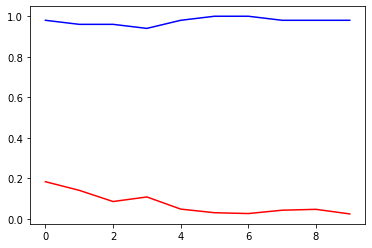

In [34]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

In [35]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [36]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Accuracy:", accuracy)

Accuracy: 0.96
